# SiteAnalysis (single site) - NDSI + bio/anthro energy

This notebook processes WAV files for a single site, computing NDSI plus anthropogenic and biophonic energy over time.

Run the configuration cell, then the analysis cell, then the plots cell (saves to disk and shows inline).


In [ ]:
from pathlib import Path
import os
import re
import sys
import time
from typing import Optional
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import numpy as np
import pandas as pd

from scipy import signal

try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = None

try:
    import soundfile as sf
except Exception:
    sf = None

try:
    import librosa
except Exception:
    librosa = None

# For running locally (Rod)
site_label = "Zapallar 32"
site_dir = Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/Zapallar/20-10-25/32")
output_dir = Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults")

# For running in Colab
# site_label = "San Antonio 28"
# site_dir = Path("/content/drive/Shareddrives/MAR FUTURA/Hydrophones/San Antonio/18-10-25/28")
# output_dir = Path("/content/drive/Shareddrives/MAR FUTURA/Hydrophones/NDSIResults")

segment_sec = 60
anthro_band = (1000, 2000)
bio_band = (2000, 3000)

tz = "UTC"
files_per_hour = 2
files_per_folder = None

start_date = None  # e.g. pd.Timestamp("2025-10-21 00:00:00", tz=tz)
end_date = None    # e.g. pd.Timestamp("2025-10-22 23:59:59", tz=tz)


In [5]:
_DT_RE = re.compile(r"^(?:ST_\d+_)?(\d{8}_\d{6})\.WAV$", re.IGNORECASE)


def extract_datetime(path: Path, tz: str = "UTC") -> pd.Timestamp:
    m = _DT_RE.match(path.name)
    if not m:
        raise ValueError(f"Filename does not match expected pattern: {path.name}")
    dt = pd.to_datetime(m.group(1), format="%Y%m%d_%H%M%S", utc=True)
    if tz.upper() == "UTC":
        return dt
    return dt.tz_convert(tz)


def read_wav_mono(path: Path, target_sr: Optional[int] = None):
    if sf is not None:
        audio, sr = sf.read(str(path), always_2d=True)
        audio = audio.mean(axis=1)
        if target_sr is not None and target_sr != sr:
            if librosa is None:
                raise RuntimeError("Resampling requested but librosa is not available")
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
            sr = target_sr
        return audio.astype(np.float32, copy=False), int(sr)

    if librosa is None:
        raise RuntimeError("Neither soundfile nor librosa is available to read WAV files")

    audio, sr = librosa.load(str(path), sr=target_sr, mono=True)
    return audio.astype(np.float32, copy=False), int(sr)


def calculate_ndsi_with_powers(audio: np.ndarray, sr: int, anthro_band, bio_band):
    f, _, Sxx = signal.spectrogram(
        audio,
        sr,
        nperseg=2048,
        noverlap=1024,
        window="hann",
    )

    anthro_idx = np.where((f >= anthro_band[0]) & (f <= anthro_band[1]))[0]
    bio_idx = np.where((f >= bio_band[0]) & (f <= bio_band[1]))[0]

    if len(anthro_idx) == 0 or len(bio_idx) == 0:
        return {"ndsi": np.nan, "anthro_energy": np.nan, "bio_energy": np.nan}

    anthro_power = float(np.mean(Sxx[anthro_idx, :]))
    bio_power = float(np.mean(Sxx[bio_idx, :]))

    denom = bio_power + anthro_power
    if denom == 0 or not np.isfinite(denom):
        return {"ndsi": np.nan, "anthro_energy": anthro_power, "bio_energy": bio_power}

    ndsi = (bio_power - anthro_power) / denom
    return {"ndsi": float(ndsi), "anthro_energy": anthro_power, "bio_energy": bio_power}


def evenly_spaced_indices(n: int, k: int) -> np.ndarray:
    if k <= 0:
        return np.array([], dtype=int)
    if n <= k:
        return np.arange(n, dtype=int)
    idx = np.round((np.arange(1, k + 1) * (n + 1)) / (k + 1)).astype(int) - 1
    idx = np.clip(idx, 0, n - 1)
    return np.unique(idx)


def select_files(files):
    rows = []
    parse_fail = 0

    for p in files:
        try:
            dt = extract_datetime(p, tz=tz)
        except Exception:
            parse_fail += 1
            continue

        if start_date is not None and dt < (start_date - pd.Timedelta(seconds=segment_sec)):
            continue
        if end_date is not None and dt > end_date:
            continue
        rows.append((p, dt))

    if parse_fail > 0:
        print(f"Skipped {parse_fail} files due to filename parse mismatch")

    if not rows:
        return []

    df = pd.DataFrame(rows, columns=["path", "dt"]).sort_values("dt")

    if files_per_hour is not None:
        df["hour"] = df["dt"].dt.floor("h")
        picked = []
        for _, g in df.groupby("hour", sort=True):
            g = g.sort_values("dt")
            idx = evenly_spaced_indices(len(g), int(files_per_hour))
            picked.append(g.iloc[idx])
        df = pd.concat(picked, ignore_index=True)

    paths = df["path"].tolist()
    if files_per_folder is not None:
        paths = paths[: int(files_per_folder)]
    return paths


def _scan_wavs_with_progress(directory: Path, label: str):
    directory = Path(directory)
    wavs = []

    t0 = time.time()
    last = t0
    scanned_dirs = 0

    print(f"Scanning for WAV files in: {directory}")

    for root, _, files in os.walk(directory):
        scanned_dirs += 1
        for name in files:
            if name.lower().endswith(".wav"):
                wavs.append(Path(root) / name)

        now = time.time()
        if now - last >= 1.0:
            elapsed = now - t0
            print(f"{label}: scanned {scanned_dirs} folders, found {len(wavs)} wavs so far ({elapsed:.0f}s)")
            last = now

    return sorted(wavs)


def process_site(directory: Path, label: str) -> pd.DataFrame:
    wavs = _scan_wavs_with_progress(directory, label)
    print(f"Found {len(wavs)} files in {label} (recursive)")

    wavs = select_files(wavs)
    print(f"Using {len(wavs)} files in {label} after filters")

    out_rows = []
    n = len(wavs)

    iterator = wavs
    use_tqdm = tqdm is not None and n > 0
    if use_tqdm:
        iterator = tqdm(wavs, desc=f"{label}: files", unit="file")

    for i, fp in enumerate(iterator, start=1):
        if not use_tqdm:
            pct = 100.0 * i / max(1, n)
            sys.stdout.write(f"\r{label}: {i}/{n} files ({pct:5.1f}%)")
            sys.stdout.flush()

        try:
            start_dt = extract_datetime(fp, tz=tz)
        except Exception:
            continue

        try:
            audio, sr = read_wav_mono(fp, target_sr=None)
        except Exception:
            continue

        if audio.size == 0 or sr <= 0:
            continue

        dur_sec = audio.size / sr
        seg_len = min(segment_sec, dur_sec)
        if not np.isfinite(seg_len) or seg_len <= 0:
            continue

        max_start = max(0.0, dur_sec - seg_len)
        starts = np.arange(0.0, max_start + 1e-9, seg_len)

        for st in starts:
            segment_time = start_dt + pd.to_timedelta(float(st), unit="s")
            if start_date is not None and segment_time < start_date:
                continue
            if end_date is not None and segment_time > end_date:
                break

            i0 = int(round(st * sr))
            i1 = int(round((st + seg_len) * sr))
            seg = audio[i0:i1]
            if seg.size == 0:
                continue

            res = calculate_ndsi_with_powers(seg, sr, anthro_band, bio_band)
            out_rows.append(
                {
                    "Site": label,
                    "Time": segment_time,
                    "NDSI": res["ndsi"],
                    "Anthro_Energy": res["anthro_energy"],
                    "Bio_Energy": res["bio_energy"],
                }
            )

    if not use_tqdm:
        sys.stdout.write("\n")
        sys.stdout.flush()

    return pd.DataFrame(out_rows)


if not site_dir.exists():
    raise RuntimeError(f"Missing site_dir: {site_dir}")

all_results = process_site(site_dir, site_label)

if all_results.empty:
    raise RuntimeError("No results produced. Check directory paths, filename patterns, and date range.")

anthro_tag = f"anthro_{anthro_band[0]}-{anthro_band[1]}"
bio_tag = f"bio_{bio_band[0]}-{bio_band[1]}"

site_tag = re.sub(r"[^A-Za-z0-9]+", "_", site_label.strip().lower()).strip("_")

output_dir.mkdir(parents=True, exist_ok=True)

out_csv = output_dir / f"ndsi_{site_tag}_{anthro_tag}_{bio_tag}.csv"
all_results.to_csv(out_csv, index=False)
print("Saved to:", out_csv)

summary_stats = (
    all_results.groupby("Site", as_index=False)
    .agg(
        Segments=("NDSI", "size"),
        Mean_NDSI=("NDSI", "mean"),
        SD_NDSI=("NDSI", "std"),
        Mean_Anthro_Energy=("Anthro_Energy", "mean"),
        SD_Anthro_Energy=("Anthro_Energy", "std"),
        Mean_Bio_Energy=("Bio_Energy", "mean"),
        SD_Bio_Energy=("Bio_Energy", "std"),
    )
)
print(summary_stats)


Found 17588 files in Zapallar 32 (recursive)
Using 882 files in Zapallar 32 after filters
Zapallar 32: processed 25/882 files
Zapallar 32: processed 50/882 files
Zapallar 32: processed 75/882 files
Zapallar 32: processed 100/882 files
Zapallar 32: processed 125/882 files
Zapallar 32: processed 150/882 files
Zapallar 32: processed 175/882 files
Zapallar 32: processed 200/882 files
Zapallar 32: processed 225/882 files
Zapallar 32: processed 250/882 files
Zapallar 32: processed 275/882 files
Zapallar 32: processed 300/882 files
Zapallar 32: processed 325/882 files
Zapallar 32: processed 350/882 files
Zapallar 32: processed 375/882 files
Zapallar 32: processed 400/882 files
Zapallar 32: processed 425/882 files
Zapallar 32: processed 450/882 files
Zapallar 32: processed 475/882 files
Zapallar 32: processed 500/882 files
Zapallar 32: processed 525/882 files
Zapallar 32: processed 550/882 files
Zapallar 32: processed 575/882 files
Zapallar 32: processed 600/882 files
Zapallar 32: processed 62

Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults/Graphs/ndsi_zapallar_32_anthro_1000-2000_bio_2000-3000_ndsi.png


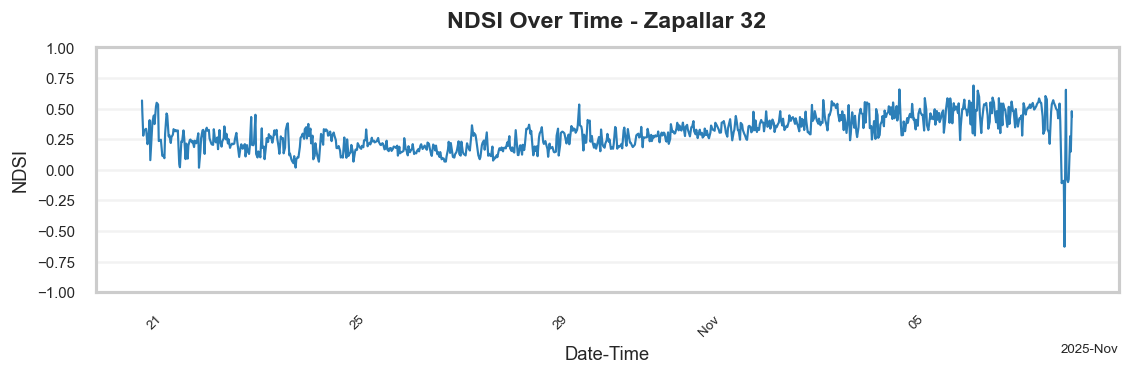

Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults/Graphs/ndsi_zapallar_32_anthro_1000-2000_bio_2000-3000_anthro_energy.png


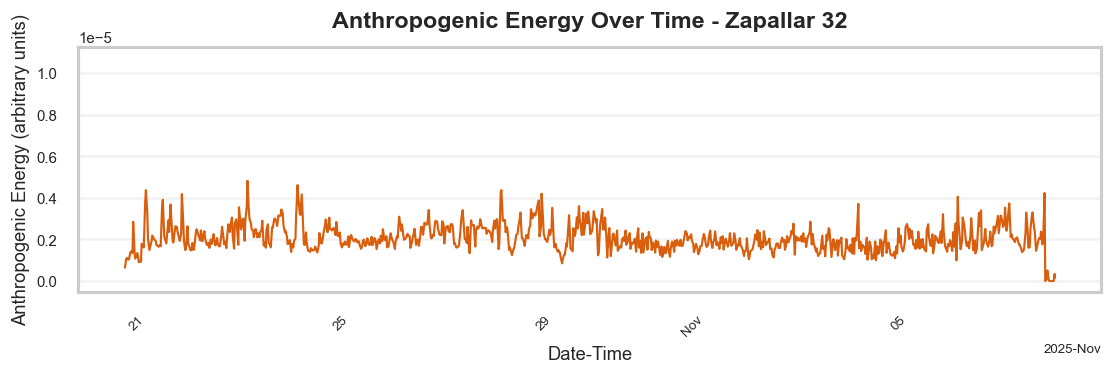

Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults/Graphs/ndsi_zapallar_32_anthro_1000-2000_bio_2000-3000_bio_energy.png


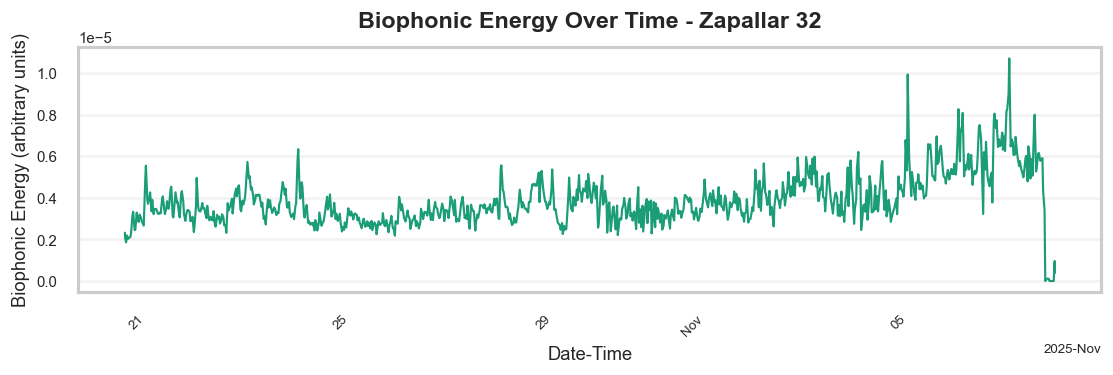

Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults/Graphs/ndsi_zapallar_32_anthro_1000-2000_bio_2000-3000_summary_stats.csv
Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults/Graphs/ndsi_zapallar_32_anthro_1000-2000_bio_2000-3000_ndsi_quadrant_table.csv


In [9]:
#Plot

# If you restart the kernel and run this cell directly, these may not be defined.
# Prefer the imports from the first cell, but fall back to importing here.
try:
    sns
except NameError:
    import seaborn as sns

try:
    plt
except NameError:
    import matplotlib.pyplot as plt

try:
    mdates
except NameError:
    import matplotlib.dates as mdates

try:
    display
except NameError:
    from IPython.display import display

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update(
    {
        "figure.dpi": 120,
        "savefig.dpi": 200,
        "axes.titlepad": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 11,
        "xtick.labelsize": 8,
        "ytick.labelsize": 9,
        "grid.alpha": 0.25,
    }
)

SHOW_PLOTS_INLINE = True

plot_data = all_results.copy()
plot_data["Time"] = pd.to_datetime(plot_data["Time"], utc=True, errors="coerce")
if plot_data["Time"].isna().any():
    plot_data["Time"] = pd.to_datetime(plot_data["Time"], errors="coerce")
if plot_data["Time"].isna().any():
    raise RuntimeError("Could not parse Time column for plotting")

graphs_dir = Path(output_dir) / "Graphs"
graphs_dir.mkdir(parents=True, exist_ok=True)
base = Path(out_csv).stem

def _finite_min_max(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce")
    s = s[np.isfinite(s)]
    if s.empty:
        return None
    return float(s.min()), float(s.max())

def _pad_limits(lims, pad_frac: float = 0.05):
    if lims is None:
        return None
    lo, hi = lims
    if not np.isfinite(lo) or not np.isfinite(hi):
        return None
    if lo == hi:
        eps = 1e-12 if lo == 0 else abs(lo) * 0.05
        return lo - eps, hi + eps
    pad = (hi - lo) * pad_frac
    return lo - pad, hi + pad

ndsi_ylim = (-1.0, 1.0)

# Use the SAME scale for both energy plots (combined min/max across both series)
energy_series = pd.concat([plot_data["Anthro_Energy"], plot_data["Bio_Energy"]], ignore_index=True)
energy_ylim = _pad_limits(_finite_min_max(energy_series))

def _single_timeseries(y_col: str, y_label: str, title: str, filename: str, ylim=None, color="#1f77b4"):
    fig, ax = plt.subplots(figsize=(11, 3))
    ax.plot(plot_data["Time"], plot_data[y_col], linewidth=1.3, color=color)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Date-Time")
    ax.set_ylabel(y_label)

    locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    fig.autofmt_xdate(rotation=45)

    if ylim is not None:
        ax.set_ylim(ylim)

    ax.grid(True, axis="y")
    ax.grid(False, axis="x")

    out_path = graphs_dir / filename
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    print("Saved:", out_path)

    if SHOW_PLOTS_INLINE:
        display(fig)

    plt.close(fig)

_single_timeseries(
    y_col="NDSI",
    y_label="NDSI",
    title=f"NDSI Over Time - {site_label}",
    filename=f"{base}_ndsi.png",
    ylim=ndsi_ylim,
    color="#2C7FB8",
)

_single_timeseries(
    y_col="Anthro_Energy",
    y_label="Anthropogenic Energy (arbitrary units)",
    title=f"Anthropogenic Energy Over Time - {site_label}",
    filename=f"{base}_anthro_energy.png",
    ylim=energy_ylim,
    color="#D95F0E",
)

_single_timeseries(
    y_col="Bio_Energy",
    y_label="Biophonic Energy (arbitrary units)",
    title=f"Biophonic Energy Over Time - {site_label}",
    filename=f"{base}_bio_energy.png",
    ylim=energy_ylim,
    color="#1B9E77",
)

quadrant = plot_data.copy()
quadrant["NDSI_Quadrant"] = pd.cut(
    quadrant["NDSI"],
    bins=[-1.0000001, -0.5, 0.0, 0.5, 1.0000001],
    labels=["[-1, -0.5)", "[-0.5, 0]", "(0, 0.5)", "[0.5, 1]"],
    include_lowest=True,
)
quadrant = quadrant.dropna(subset=["NDSI_Quadrant"]).copy()
quadrant["NDSI_Quadrant"] = quadrant["NDSI_Quadrant"].astype(str)

ndsi_quadrant_table = (
    quadrant.groupby(["Site", "NDSI_Quadrant"], as_index=False, observed=True)
    .agg(Segments=("NDSI", "size"))
)
ndsi_quadrant_table["Total_Segments"] = ndsi_quadrant_table.groupby("Site")["Segments"].transform("sum")
ndsi_quadrant_table["Percent_Time"] = 100.0 * ndsi_quadrant_table["Segments"] / ndsi_quadrant_table["Total_Segments"]

summary_path = graphs_dir / f"{base}_summary_stats.csv"
quadrant_path = graphs_dir / f"{base}_ndsi_quadrant_table.csv"

summary_stats.to_csv(summary_path, index=False)
ndsi_quadrant_table.to_csv(quadrant_path, index=False)

print("Saved:", summary_path)
print("Saved:", quadrant_path)
